# Importing Line

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER   = '../Data/Lines/'

line   = {}
twiss  = {}
survey = {}

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')

    # Building tracker
    line[_beam].build_tracker()

    # Extracting twiss and survey
    twiss[_beam]  = line[_beam].twiss().to_pandas(index="name")
    survey[_beam] = line[_beam].survey().to_pandas(index="name")

    if _beam == 'b4':
        twiss['b2']   = line[_beam].twiss().reverse().to_pandas(index="name")
        survey['b2']  = line[_beam].survey().reverse().to_pandas(index="name")

# Clearing xsuite ouput
clear_output(wait=False)



# # Filtering twiss
# #====================================
# twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
# twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
# #====================================








In [2]:
# Adding aperture
collimator_h  = xt.LimitRect(   min_x=-1e-3 , max_x=1e-3,
                                min_y=-10e-2, max_y=10e-2)

collimator_v  = xt.LimitRect(   min_x=-10e-2, max_x=10e-2,
                                min_y=-1e-3 , max_y=1e-3)


tcp_apertures = {   'tcpcv.a6l7.b1': collimator_v,
                    'tcpch.a4l7.b1': collimator_h}

_beam = 'b1'
line[_beam].discard_tracker()
for ee,aper in tcp_apertures.items():
    line[_beam].insert_element(element=aper, name=ee+'_aper', index=ee)

# Overwriting twiss
line[_beam].build_tracker()
twiss[_beam]  = line[_beam].twiss().to_pandas(index="name")
survey[_beam] = line[_beam].survey().to_pandas(index="name")

Compiling ContextCpu kernels...


53e6dd34baec474d8531859196dac3a8.c:4389:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include/python3.11/pyconfig.h:1687:10: note: previous definition is here
# define _GNU_SOURCE 1
         ^
53e6dd34baec474d8531859196dac3a8.c:16679:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma = energy / m0; // [1] 
           ^
2 warnings generated.


Done compiling ContextCpu kernels.


# Tracking test

Warning! The argument tracker is deprecated. Please use line instead.
Warning! scale_with_transverse_norm_emitt is deprecated. Use nemitt_x and nemitt_y instead.
Tracking first test.. 


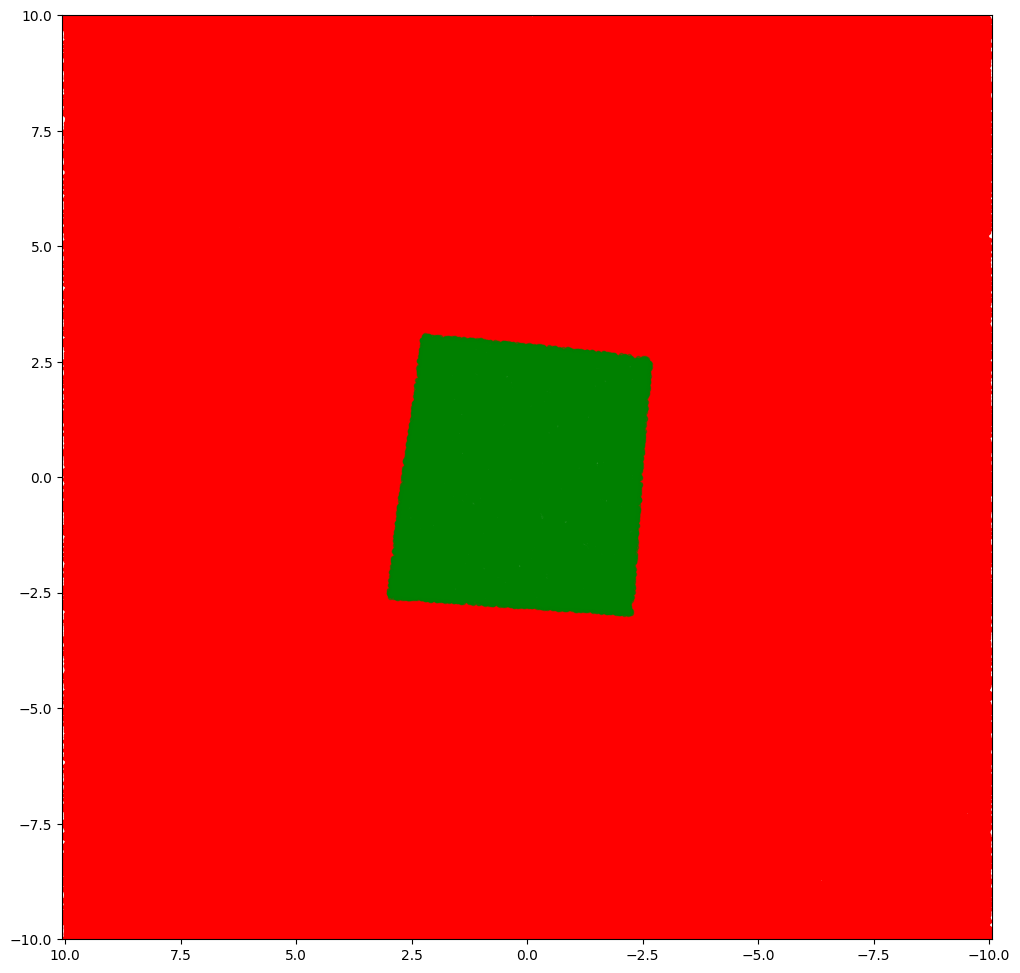

In [6]:
# --------------------------------------------------------
# ------------------ Tracking (test 1) -------------------
# --------------------------------------------------------
#
# As a first test, we just track 5 turns.
# We expect to see the transversal profile generated by
# the three primaries opened at 5 sigma.


# Create initial particles
n_sigmas = 10
n_part = 500000
x_norm = np.random.uniform(-n_sigmas, n_sigmas, n_part)
y_norm = np.random.uniform(-n_sigmas, n_sigmas, n_part)
px_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
py_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
part = xp.build_particles(tracker=line['b1'].tracker, x_norm=x_norm, y_norm=y_norm,#px_norm=px_norm, py_norm=py_norm,
                          scale_with_transverse_norm_emitt=(3.5e-6, 3.5e-6),
                          at_element='tcp.d6l7.b1',
                          #match_at_s=coll_manager.s_match['tcp.d6l7.b1']
                         )

# Track
print("Tracking first test.. ")
line['b1'].track(part, num_turns=5)

# The survival flags are sorted as surviving particles first,
# hence we need to 'unsort' them using their IDs
surv = part.state.copy()
surv[part.particle_id] = part.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()



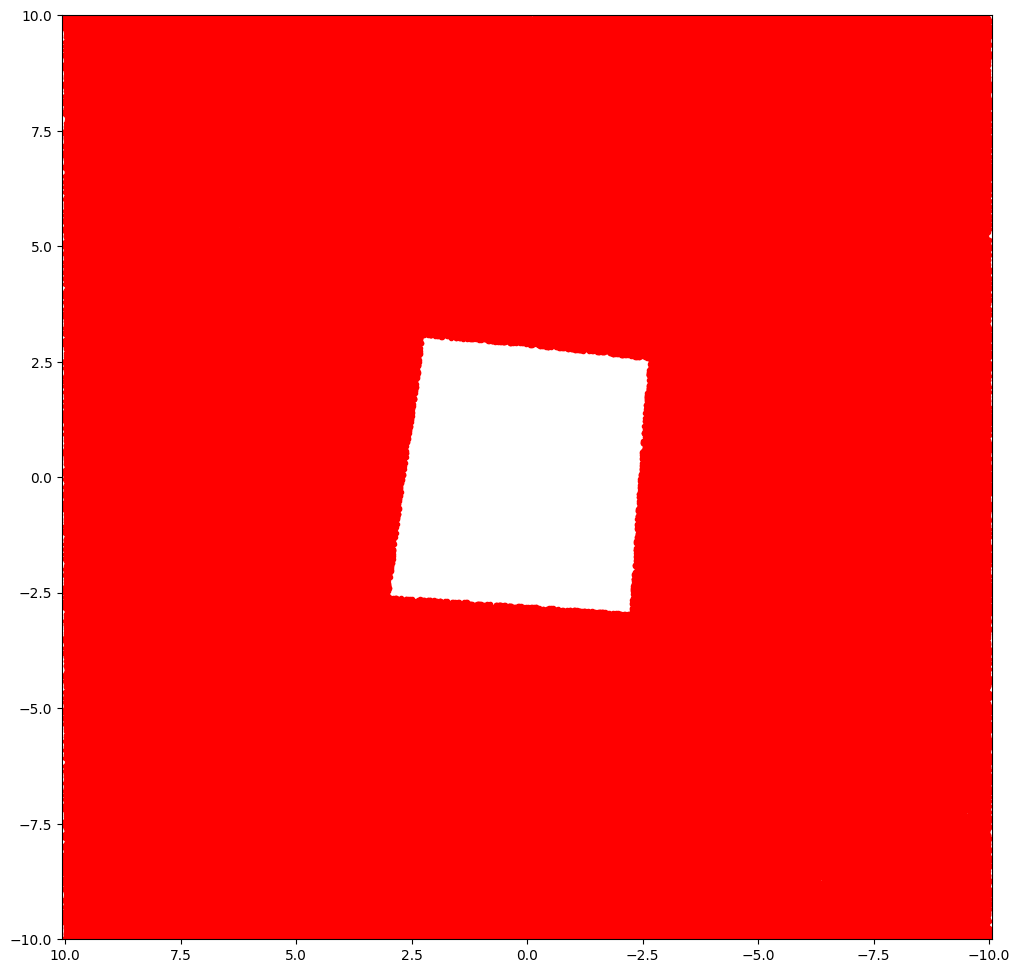

In [13]:
# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red',alpha=1)
# plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green')
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
plt.show()

In [73]:
np.sqrt(twiss['b1'].loc['tcp.d6l7.b1'].bety*3.5e-6/6500)/1e-3 * 10

1.9963169538788943

In [23]:
line['b1'].check_aperture()

KeyboardInterrupt: 

In [76]:
[ee for ee in list(line['b1'].element_names) if 'tcp' in ee]

['tcp.d6l7.b1',
 'tcp.c6l7.b1',
 'tcp.b6l7.b1',
 'tcpcv.a6l7.b1_aper',
 'tcpcv.a6l7.b1',
 'tcpch.a4l7.b1_aper',
 'tcpch.a4l7.b1',
 'tcp.6l3.b1']

In [54]:
line['b1'].elements[line['b1'].element_names.index('tcpcv.a6l7.b1_aper')]

AttributeError: 'Drift' object has no attribute 'aperture'

27221

In [43]:
line['b1'].elements['tcpcv.a6l7.b1_aper']

TypeError: tuple indices must be integers or slices, not str

In [40]:
line['b1'].elements[list(tcp_apertures.keys())[1]]

TypeError: tuple indices must be integers or slices, not str

In [24]:
[nn for nn in line['b1'].element_names if '_aper' in nn]

['tcpcv.a6l7.b1_aper', 'tcpch.a4l7.b1_aper']

In [3]:
twiss

{'b1':                        s             x            px             y  \
 name                                                                 
 ip3               0.0000 -1.155255e-07 -4.766949e-09  1.757476e-07   
 drift_0           0.0000 -1.155255e-07 -4.766949e-09  1.757476e-07   
 mcbwv.4r3.b1     21.0300 -2.157744e-07 -4.766949e-09  2.308550e-07   
 drift_1          21.0300 -2.157744e-07 -4.766949e-09  2.308550e-07   
 bpmw.4r3.b1      22.5205 -2.228795e-07 -4.766949e-09  2.347607e-07   
 ...                  ...           ...           ...           ...   
 drift_30723   26636.4387 -8.533768e-09 -4.766949e-09  1.169338e-07   
 mcbwh.4l3.b1  26640.1832 -2.638360e-08 -4.766949e-09  1.267459e-07   
 drift_30724   26640.1832 -2.638360e-08 -4.766949e-09  1.267459e-07   
 lhcb1ip3_p_   26658.8832 -1.155255e-07 -4.766949e-09  1.757476e-07   
 _end_point    26658.8832 -1.155255e-07 -4.766949e-09  1.757476e-07   
 
                         py          zeta         delta          ptau

In [3]:
line = xt.Line.from_json(LINEFOLDER + f'line_opticsfile32_{seq}.json')

Done loading line from dict.           


In [5]:
line.particle_ref

In [4]:
line_test = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')

Done loading line from dict.           


In [6]:
line_test.particle_ref

Particles(_capacity=1, _num_active_particles=1, _num_lost_particles=0, start_tracking_at_element=-1, q0=1.0, mass0=938272088.16, _p0c=[6.79999994e+12], _gamma0=[7247.36468857], _beta0=[0.99999999], s=[0.], zeta=[1.02733591e-07], _ptau=[4.52392643e-07], _delta=[4.52392647e-07], _rpp=[0.99999955], _rvv=[1.], chi=[1.], charge_ratio=[1.], weight=[1.], particle_id=[0], at_element=[0], at_turn=[0], state=[1], parent_particle_id=[0], _rng_s1=[0], _rng_s2=[0], _rng_s3=[0], _rng_s4=[0], x=[-1.15452677e-07], y=[1.75657612e-07], px=[-4.76933733e-09], py=[2.61995815e-09])

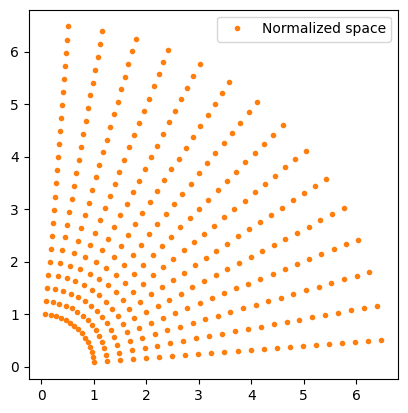

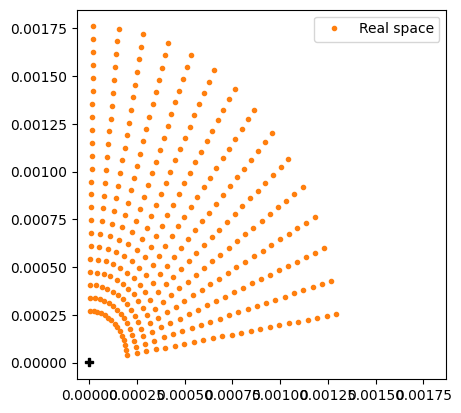

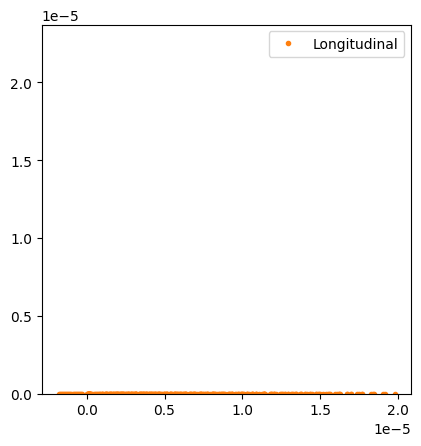

In [2]:


def generate_particles():
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                    emitt     = [B1.emittx,B1.emitty])
    coordinates.insert(0,'delta',0)
    group_length = len(coordinates)

    #coordinates = pd.concat([coordinates,coordinates,coordinates],ignore_index=True)
    #coordinates.loc[group_length:2*group_length,'delta'] = 0.55e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c
    #coordinates.loc[2*group_length:,'delta']             = 1.10e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c



    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles,coordinates = generate_particles()


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles.x   ,particles.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()


plt.figure()
plt.plot(particles.zeta   ,particles.delta    ,'.',color='C1',label='Longitudinal')
plt.axis('square')
plt.legend()



---

# Tracking

In [3]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1
tracker.match(vary=['dqx.b1','dqy.b1'], 
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================



Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00000 Q'y = 15.00000


In [4]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

particles,coordinates = generate_particles()
tracked_ref = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)




# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1/10
tracker.vars[f'ip5_bbho_ON'] = 1/10

tracker.vars[f'ip1_bblr_ON'] = 1/10
tracker.vars[f'ip5_bblr_ON'] = 1/10

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles()
tracked = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)


# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0

#trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
#trackTwiss.set_index('name',inplace=True)





Output()

generating ./4a2018bb4e24405d927a30815a84d3ed.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '4a2018bb4e24405d927a30815a84d3ed' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 4a2018bb4e24405d927a30815a84d3ed.c -o ./4a2018bb4e24405d927a30815a84d3ed.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./4a2018bb4e24405d927a30815a84d3ed.o -o ./4a2018bb4e24405d927a30815a84d3ed.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


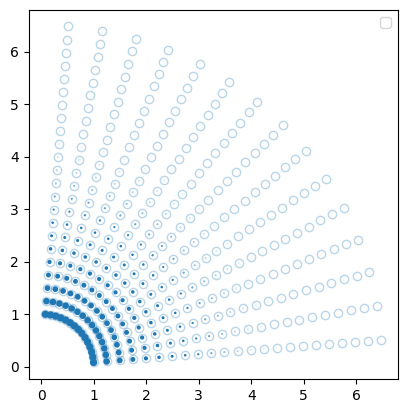

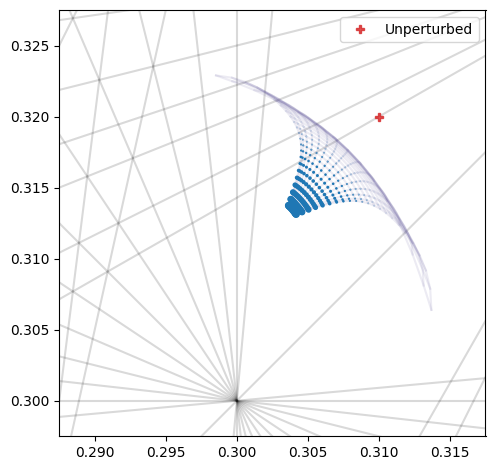

In [11]:
import scipy.stats as sciStat


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
plt.legend()
plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting



# ALL PARTICLES
chosen_particles = (coordinates['r_sig']>0)

Qx_tot = np.zeros(len(coordinates[chosen_particles]))+ Qx_0
Qy_tot = np.zeros(len(coordinates[chosen_particles]))+ Qy_0
plt.figure()

# orders = list(np.arange(12)+1)[::-1]
# lws    = np.linspace(1,8,len(orders))
# alphas = np.linspace(0.01,0.6,len(orders))

# for order,lw,alpha in zip(orders,lws,alphas):
#     bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=alpha)
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

Qx = Qx_0 + dQx*10
Qy = Qy_0 + dQy*10
#---------------

bbplt.polarmesh(Qx,Qy,alpha=0.1,r=coordinates[chosen_particles]['r_sig'],theta=coordinates[chosen_particles]['theta_sig'],color='darkslateblue')
plt.scatter(Qx,Qy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()
plt.savefig('footprint_all_scaled.png',format='png',dpi=300)


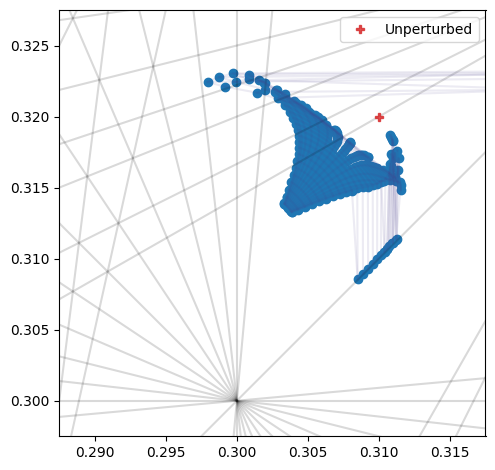

In [11]:
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
#---------------
tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

Qx = Qx_0 + dQx
Qy = Qy_0 + dQy
#---------------

bbplt.polarmesh(Qx,Qy,alpha=0.1,r=coordinates[chosen_particles]['r_sig'],theta=coordinates[chosen_particles]['theta_sig'],color='darkslateblue')
plt.scatter(Qx,Qy)#s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()

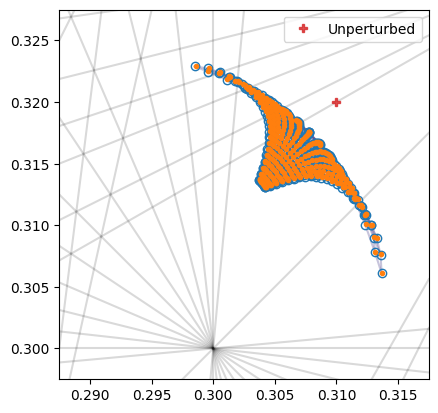

In [6]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'o',mfc='none')

tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results+[tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
plt.plot(Qx_tot,Qy_tot,'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig/footprint_TOTAL.png',format='png')

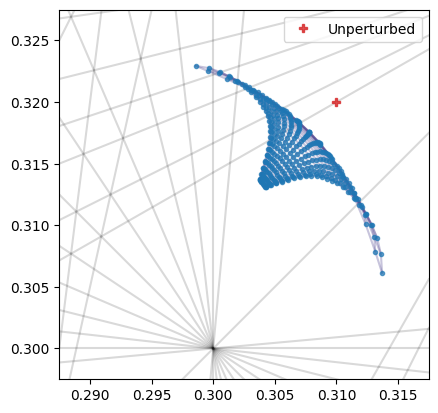

In [7]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig2/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig2/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'.',alpha=0.7)

plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig2/footprint_TOTAL.png',format='png')

In [8]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/BBStudies/Executables/py_BB/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


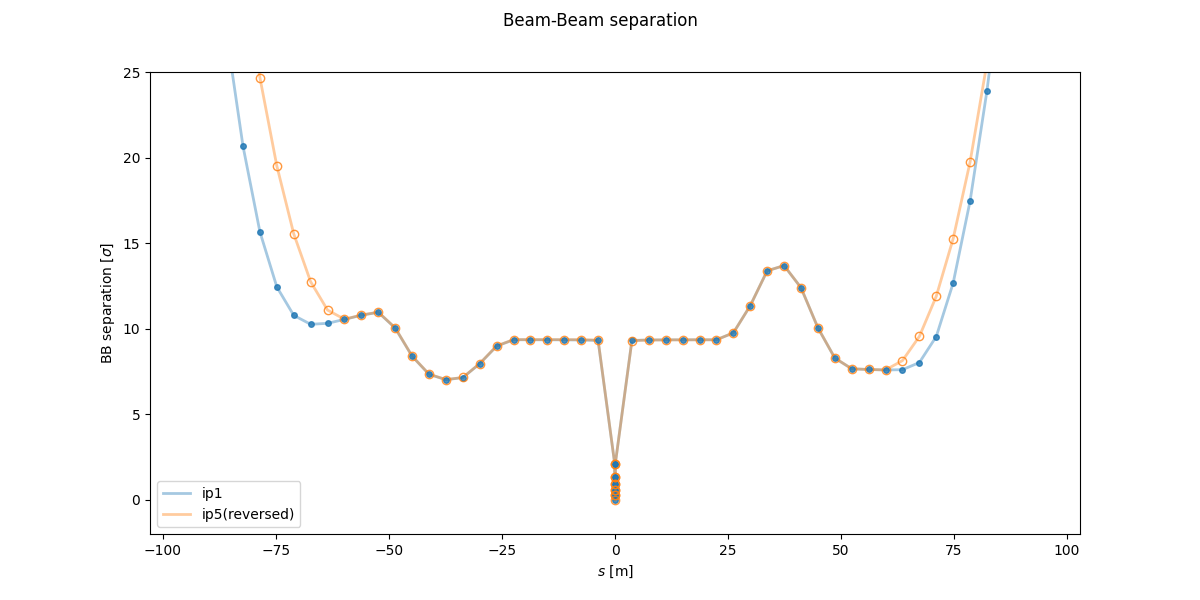

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])